In [53]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
from sklearn.cluster import KMeans
from skill_util import *
import matplotlib

### ONet 51 - Nov 2003, Onet 23 - August 2018



### Read database

In [54]:
activity_new = pd.read_excel('/home/olam/skillevo/db_23_0_excel/Work Activities.xlsx')
jobzones_new = pd.read_excel('/home/olam/skillevo/db_23_0_excel/Job Zones.xlsx', name = 'jobzones_new')


In [55]:
activity_old = pd.read_csv('/home/olam/skillevo/db_51/WorkActivity.txt', delimiter = '\t')
jobzones_old = pd.read_csv('/home/olam/skillevo/db_51/onetsoc_job_zones.txt', delimiter = '\t')


### Preprocessing

We examined the skill files only.
First, we merge data sets in two periods by the 6 digits of the onet codes. We first collapse the jobs that share the first 6 digits by averaging the Data Values. This means that only jobs that show up in both periods will be present in our analysis. we examine the difference in mean importance of each skill to the job. 

1. Our result indicates that interacting with computers become more important over time for those jobs, as well as, some team building skills
2. All but one skill (Handling and Moving Objects) increased in importance 


In [56]:
jobzones_new['O*NET-SOC Code'] = jobzones_new['O*NET-SOC Code'].str[:7]
jobzones_old['O*NET-SOC Code'] = jobzones_old['O*NET-SOC Code'].str[:7]


In [57]:
activity_old['O*NET-SOC Code'] = activity_old['O*NET-SOC Code'].str[:7]
activity_new['O*NET-SOC Code'] = activity_new['O*NET-SOC Code'].str[:7]
#get list of jobs that show up in both periods
job_first_period = activity_old['O*NET-SOC Code'].unique().tolist()
job_second_period = activity_new['O*NET-SOC Code'].unique().tolist()
job_both_periods = list(set(job_first_period) & set(job_second_period))
#get the list of jobs that shows up in the second period only
newjobs = list(set(job_second_period) - set(job_first_period))
df_newjobs =  activity_new[activity_new['O*NET-SOC Code'].isin(newjobs)]
disappeared_jobs = list(set(job_first_period) - set(job_second_period))
df_disappearedjobs =  activity_old[activity_old['O*NET-SOC Code'].isin(disappeared_jobs)]
print 'number of new jobs:', len(newjobs)
print 'number of disappeared jobs:', len(disappeared_jobs)

number of new jobs: 129
number of disappeared jobs: 35


In [58]:
#include only jobs that appear in both periods
activity_old = activity_old[activity_old['O*NET-SOC Code'].isin(job_both_periods)]
activity_new = activity_new[activity_new['O*NET-SOC Code'].isin(job_both_periods)]
#Collapse the jobs by taking average of the data value for each SOC Code
activity_old = activity_old.groupby(['O*NET-SOC Code','Element ID','Scale ID', 'Element Name'])['Data Value'].mean().reset_index()
activity_new = activity_new.groupby(['O*NET-SOC Code','Element ID','Scale ID', 'Element Name'])['Data Value'].mean().reset_index()

#also have to take average of job zones - in this case 
jobzones_new = jobzones_new.groupby(['O*NET-SOC Code'])['Job Zone'].mean().round().reset_index()
jobzones_old = jobzones_old.groupby(['O*NET-SOC Code'])['Job Zone'].mean().round().reset_index()

activity_old = activity_old[activity_old['Scale ID']=='IM']
activity_new = activity_new[activity_new['Scale ID']=='IM']

In [59]:
print 'number of jobs in both periods', len(job_both_periods)

number of jobs in both periods 644


In [60]:
print 'total number of activities', activity_new['Element ID'].nunique()

total number of activities 41


### Linking it to Employment/Income Data, and Job Zones

In [61]:

emp_17 = pd.read_excel('OES Emp and Wages_2017.xlsx')
emp_03 = pd.read_excel('OES Emp and Wages_2003.xlsx')

emp_03.columns = [x.upper() for x in emp_03.columns]


In [62]:
activity_new = pd.merge(activity_new, emp_17, left_on = 'O*NET-SOC Code', right_on = 'OCC_CODE', how = 'left')
activity_old = pd.merge(activity_old, emp_03, left_on = 'O*NET-SOC Code', right_on = 'OCC_CODE', how = 'left')

In [63]:
## Linking it with Job Zones
activity_new = pd.merge(activity_new, jobzones_new, on = 'O*NET-SOC Code', how = 'left')
activity_old = pd.merge(activity_old, jobzones_old, on = 'O*NET-SOC Code', how = 'left')


In [64]:
# most important activity by median 
print 'first period', activity_old.groupby(['Element Name'])['Data Value'].median().sort_values(ascending = False).reset_index().head(10)

print 'second period', activity_new.groupby(['Element Name'])['Data Value'].median().sort_values(ascending = False).reset_index().head(10)

first period                                         Element Name  Data Value
0                                Getting Information        4.00
1                        Handling and Moving Objects        3.50
2           Identifying Objects, Actions, and Events        3.40
3      Monitor Processes, Materials, or Surroundings        3.33
4  Communicating with Supervisors, Peers, or Subo...        3.16
5                  Documenting/Recording Information        3.00
6  Evaluating Information to Determine Compliance...        3.00
7              Making Decisions and Solving Problems        3.00
8    Communicating with Persons Outside Organization        2.83
9  Judging the Qualities of Things, Services, or ...        2.83
second period                                         Element Name  Data Value
0                                Getting Information      4.2000
1  Communicating with Supervisors, Peers, or Subo...      3.9400
2              Making Decisions and Solving Problems      3.900

The below ranks the skill importance by the 25th and 75th percentile. There are some minor differences with the median but overall, do not appear to be very different 

In [65]:
#At the 25% quantile of importance
print 'first period', activity_old.groupby(['Element Name'])['Data Value'].quantile(0.25).sort_values(ascending = False).reset_index().head(10)

print 'second period', activity_new.groupby(['Element Name'])['Data Value'].quantile(0.25).sort_values(ascending = False).reset_index().head(10)

first period                                         Element Name  Data Value
0                                Getting Information    3.426250
1           Identifying Objects, Actions, and Events    2.830000
2      Monitor Processes, Materials, or Surroundings    2.775000
3                        Handling and Moving Objects    2.580000
4  Evaluating Information to Determine Compliance...    2.500000
5  Judging the Qualities of Things, Services, or ...    2.330000
6              Making Decisions and Solving Problems    2.330000
7  Estimating the Quantifiable Characteristics of...    2.248333
8  Communicating with Supervisors, Peers, or Subo...    2.190000
9                      Analyzing Data or Information    2.160000
second period                                         Element Name  Data Value
0                                Getting Information    3.940000
1  Communicating with Supervisors, Peers, or Subo...    3.660000
2              Making Decisions and Solving Problems    3.55000

In [66]:
#At the 75% quantile of importance
print 'first period', activity_old.groupby(['Element Name'])['Data Value'].quantile(0.75).sort_values(ascending = False).reset_index().head(10)

print 'second period', activity_new.groupby(['Element Name'])['Data Value'].quantile(0.75).sort_values(ascending = False).reset_index().head(10)

first period                                         Element Name  Data Value
0                                Getting Information     4.39250
1                        Handling and Moving Objects     4.20000
2           Identifying Objects, Actions, and Events     3.88375
3      Monitor Processes, Materials, or Surroundings     3.83000
4  Communicating with Supervisors, Peers, or Subo...     3.83000
5              Making Decisions and Solving Problems     3.68500
6    Communicating with Persons Outside Organization     3.66000
7                  Documenting/Recording Information     3.66000
8             Performing General Physical Activities     3.66000
9                 Controlling Machines and Processes     3.60000
second period                                         Element Name  Data Value
0                                Getting Information     4.42000
1                         Interacting With Computers     4.23000
2              Making Decisions and Solving Problems     4.2200

In [67]:
df = pd.merge(activity_old, activity_new, on = ['O*NET-SOC Code','Element ID','Scale ID', 'Element Name'], how = 'outer')
df['value_gap'] = df['Data Value_y'] - df['Data Value_x']
df['percent_change'] = df['value_gap']/df['Data Value_x']*100
df.to_csv('activity_importance_difference_by_SOC.csv')

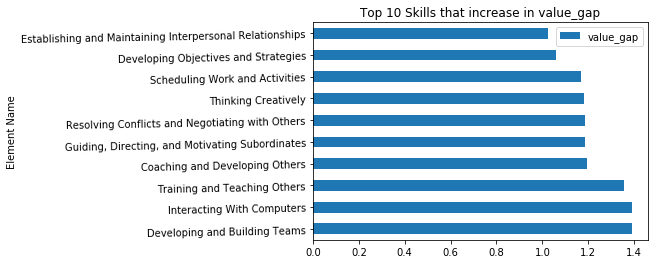

In [68]:
plot_important_skills(df, value = 'value_gap')

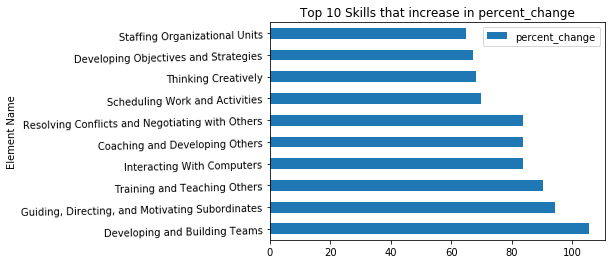

In [69]:
plot_important_skills(df, value = 'percent_change')

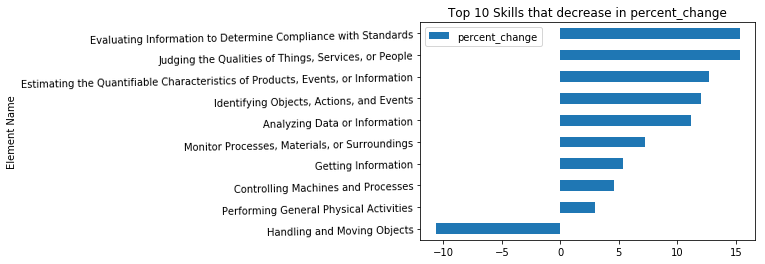

In [70]:
plot_important_skills(df, value = 'percent_change', low2high= True)

Next we replicate the RCA calculation for the SKILL files 

In [25]:
activity_new= activity_new[activity_new['Scale ID']=='IM']
temp = calc_rca(activity_new)

KeyboardInterrupt: 

In [41]:
temp.to_csv('activity_new_rca.csv')

In [42]:
activity_old= activity_old[activity_old['Scale ID']=='IM']
temp_old = calc_rca(activity_old)

In [43]:
temp_old.to_csv('activity_old_rca.csv')

In [46]:
temp = pd.read_csv('activity_new_rca.csv')
temp_old = pd.read_csv('activity_old_rca.csv')
df_rca = pd.merge(temp, temp_old, on = ['O*NET-SOC Code','Element ID','Scale ID','Element Name'], how = 'outer')
df_rca['value_gap'] = df_rca['rca_x'] - df_rca['rca_y']
df_rca['percent_change'] = df_rca['value_gap']/df_rca['rca_y']*100

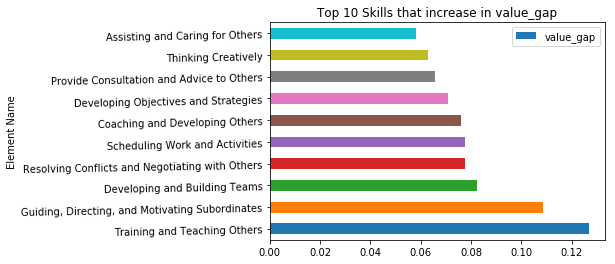

In [47]:
plot_important_skills(df_rca, value = 'value_gap')

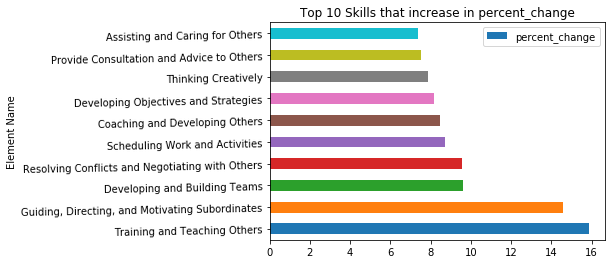

In [48]:
plot_important_skills(df_rca, value = 'percent_change')

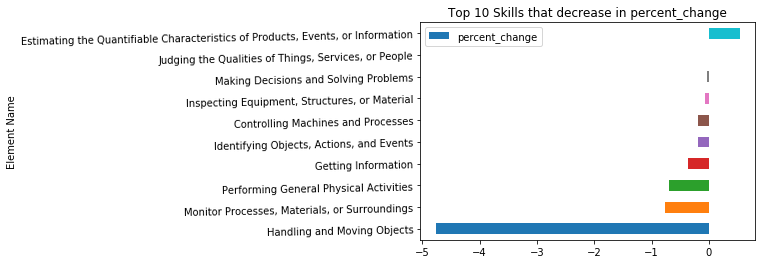

In [49]:
plot_important_skills(df_rca, value = 'percent_change', low2high= True)

## Skills Cluster

### The analysis plan:

The first analysis uses principal component on the data of a given year, to determine which two components can explain the most variation in skill/knowledge/activities among jobs. We convert the dataframe of skills from long to wide.   We then use PCA to figure out the most important dimensions of skills for the jobs. And once we determine the first 2 skills dimensions, we can plot the jobs on a 2-d plane to determine how different job zones have different skill requirement.

#### Interpreting the Principal Components with Original Vairables
This analysis examines what these Principal components actually mean. To do that, we simply calculate the correlation between principal component 1 with the rest of the skill requirements, and print out the skills that are most correlated with each components



In [73]:
temp = pd.read_csv('activity_old_rca.csv')
finalDf = pca_df(temp, value = 'rca')
finalDf['O*NET-SOC Code'].nunique()

622

#### Skill Files - this section examines the PCA of skills files 

                                                principal component 1
principal component 1                                        1.000000
Inspecting Equipment, Structures, or Material                0.924685
Controlling Machines and Processes                           0.913458
Repairing and Maintaining Mechanical Equipment               0.898583
Handling and Moving Objects                                  0.891126
Performing General Physical Activities                       0.815019
                                          principal component 2
principal component 2                                  1.000000
Processing Information                                 0.654696
Getting Information                                    0.624144
Identifying Objects, Actions, and Events               0.572281
Analyzing Data or Information                          0.535001
Documenting/Recording Information                      0.479315
Updating and Using Relevant Knowledge                  0.46647

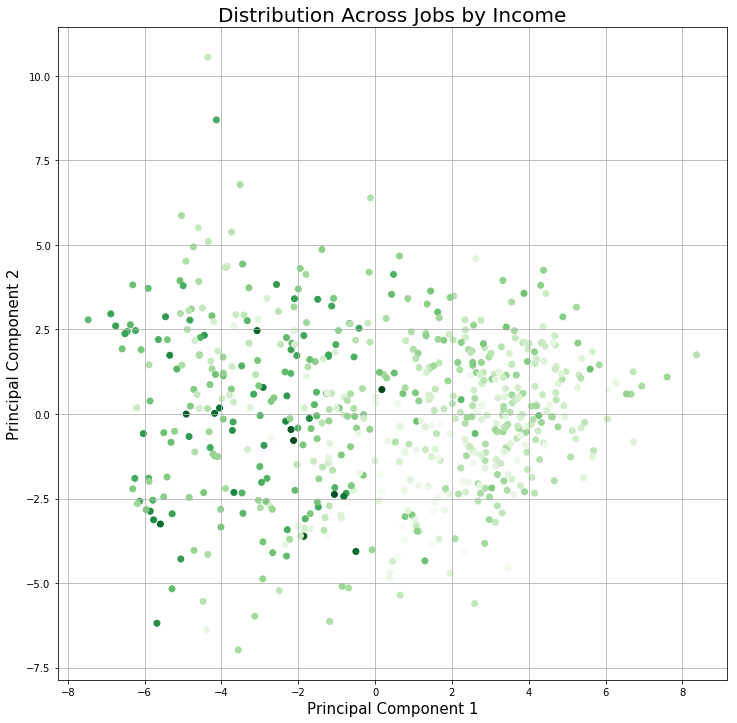

In [15]:
temp = pd.read_csv('activity_new_rca.csv')
finalDf = pca_df(temp, value = 'rca')
finalDf['H_MEAN'] = finalDf['H_MEAN'].replace('*', np.nan)
finalDf['H_MEAN'] = pd.to_numeric(finalDf['H_MEAN'], errors='coerce')
render_pca_plot(finalDf, color_code = 'income', cm_scheme = 'Greens')

temp2 = temp.pivot_table(index = ['O*NET-SOC Code'], columns = 'Element Name', values = 'rca').reset_index()
df = pd.merge(temp2, finalDf, on = ['O*NET-SOC Code'])
df = df.corr()
df = df.drop('Job Zone', 1)
df = df.drop(['Job Zone'])
print df[['principal component 1']].sort_values('principal component 1', ascending = False).head(6)
print df[['principal component 2']].sort_values('principal component 2', ascending = False).head(7)

In [25]:
from math import sqrt

### Computing distance between centroids of job zones

In [52]:
temp = pd.read_csv('activity_new_rca.csv')
finalDf = pca_df(temp, value = 'rca')

job_zones = [1.,2.,3.,4.,5.]
centroid_list = []
for job_zone in job_zones:
    temp = finalDf[finalDf['Job Zone']==job_zone]
    centroid_list.append({'job_zone': job_zone, 'x':temp['principal component 1'].sum()/len(temp), 'y':temp['principal component 2'].sum()/len(temp) })
centroid_df = pd.DataFrame.from_records(centroid_list)   
sqrt( (centroid_df[centroid_df['job_zone']==5].x.values-centroid_df[centroid_df['job_zone']==2].x.values)**2 + 
     (centroid_df[centroid_df['job_zone']==5].y.values-centroid_df[centroid_df['job_zone']==2].y.values)**2)

6.1736307891342594

In [51]:
temp = pd.read_csv('activity_old_rca.csv')
finalDf = pca_df(temp, value = 'rca')

job_zones = [1.,2.,3.,4.,5.]
centroid_list = []
for job_zone in job_zones:
    temp = finalDf[finalDf['Job Zone']==job_zone]
    centroid_list.append({'job_zone': job_zone, 'x':temp['principal component 1'].sum()/len(temp), 'y':temp['principal component 2'].sum()/len(temp) })
centroid_df = pd.DataFrame.from_records(centroid_list)   
sqrt( (centroid_df[centroid_df['job_zone']==5].x.values-centroid_df[centroid_df['job_zone']==2].x.values)**2 + 
     (centroid_df[centroid_df['job_zone']==5].y.values-centroid_df[centroid_df['job_zone']==2].y.values)**2)

4.890530848082039

                                                principal component 1
principal component 1                                        1.000000
Inspecting Equipment, Structures, or Material                0.924685
Controlling Machines and Processes                           0.913458
Repairing and Maintaining Mechanical Equipment               0.898583
Handling and Moving Objects                                  0.891126
Performing General Physical Activities                       0.815019
                                          principal component 2
principal component 2                                  1.000000
Processing Information                                 0.654696
Getting Information                                    0.624144
Identifying Objects, Actions, and Events               0.572281
Analyzing Data or Information                          0.535001
Documenting/Recording Information                      0.479315
Updating and Using Relevant Knowledge                  0.46647

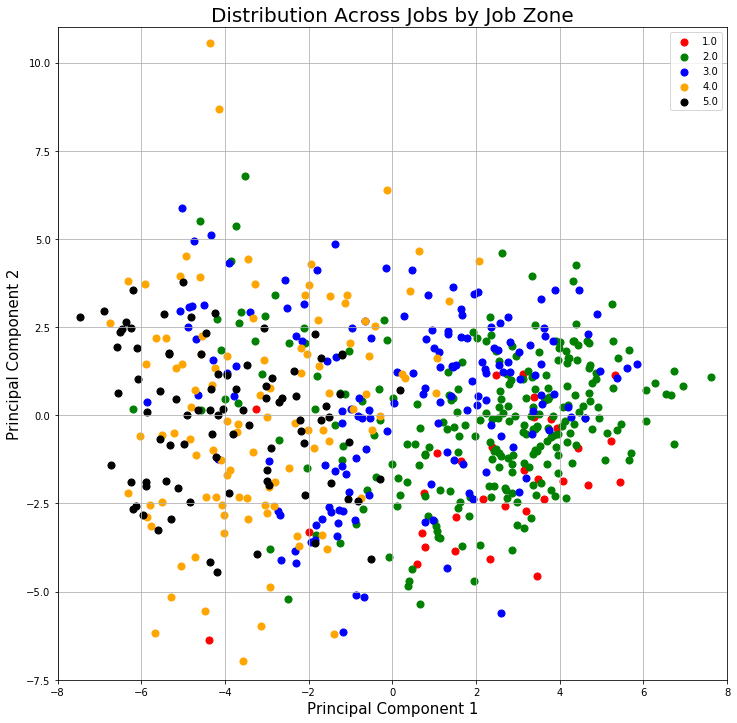

In [3]:
temp = pd.read_csv('activity_new_rca.csv')
finalDf = pca_df(temp, value = 'rca')
finalDf['H_MEAN'] = finalDf['H_MEAN'].replace('*', np.nan)
finalDf['H_MEAN'] = pd.to_numeric(finalDf['H_MEAN'], errors='coerce')
render_pca_plot(finalDf, color_code = 'job_zone')

temp2 = temp.pivot_table(index = ['O*NET-SOC Code'], columns = 'Element Name', values = 'rca').reset_index()
df = pd.merge(temp2, finalDf, on = ['O*NET-SOC Code'])
df = df.corr()
df = df.drop('Job Zone', 1)
df = df.drop(['Job Zone'])
print df[['principal component 1']].sort_values('principal component 1', ascending = False).head(6)
print df[['principal component 2']].sort_values('principal component 2', ascending = False).head(7)

                                                principal component 1
principal component 1                                        1.000000
Handling and Moving Objects                                  0.867054
Controlling Machines and Processes                           0.858820
Inspecting Equipment, Structures, or Material                0.831821
Repairing and Maintaining Mechanical Equipment               0.784428
Performing General Physical Activities                       0.735266
                                          principal component 2
principal component 2                                  1.000000
Analyzing Data or Information                          0.786989
Processing Information                                 0.731384
Identifying Objects, Actions, and Events               0.565560
Updating and Using Relevant Knowledge                  0.543811
Making Decisions and Solving Problems                  0.520206
Getting Information                                    0.48606

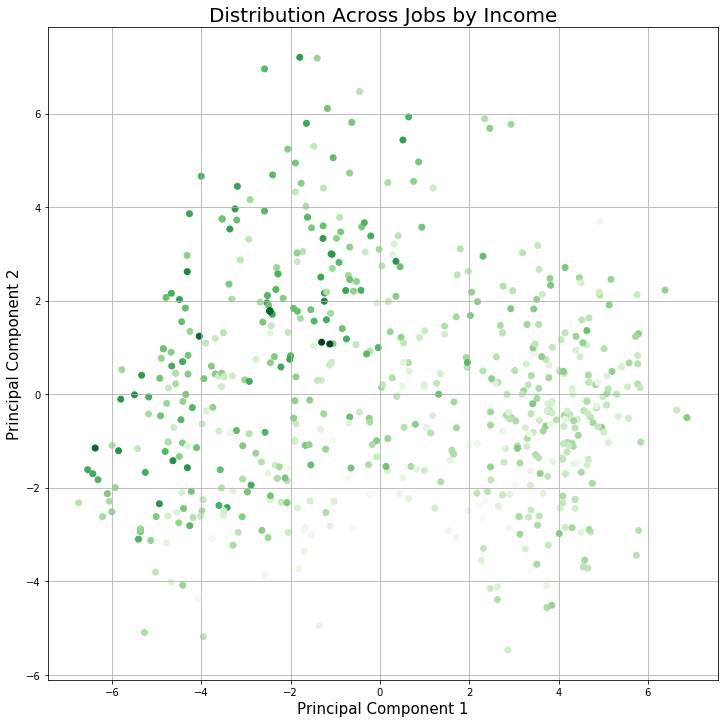

In [20]:
temp = pd.read_csv('activity_old_rca.csv')
finalDf = pca_df(temp, value = 'rca')
finalDf['H_MEAN'] = finalDf['H_MEAN'].replace('*', np.nan)
finalDf['H_MEAN'] = pd.to_numeric(finalDf['H_MEAN'], errors='coerce')
render_pca_plot(finalDf, color_code = 'income', cm_scheme = 'Greens')

temp2 = temp.pivot_table(index = ['O*NET-SOC Code'], columns = 'Element Name', values = 'rca').reset_index()
df = pd.merge(temp2, finalDf, on = ['O*NET-SOC Code'])
df = df.corr()
df = df.drop('Job Zone', 1)
df = df.drop(['Job Zone'])
print df[['principal component 1']].sort_values('principal component 1', ascending = False).head(6)
print df[['principal component 2']].sort_values('principal component 2', ascending = False).head(7)

                                                principal component 1
principal component 1                                        1.000000
Handling and Moving Objects                                  0.867054
Controlling Machines and Processes                           0.858820
Inspecting Equipment, Structures, or Material                0.831821
Repairing and Maintaining Mechanical Equipment               0.784428
Performing General Physical Activities                       0.735266
                                          principal component 2
principal component 2                                  1.000000
Analyzing Data or Information                          0.786989
Processing Information                                 0.731384
Identifying Objects, Actions, and Events               0.565560
Updating and Using Relevant Knowledge                  0.543811
Making Decisions and Solving Problems                  0.520206
Getting Information                                    0.48606

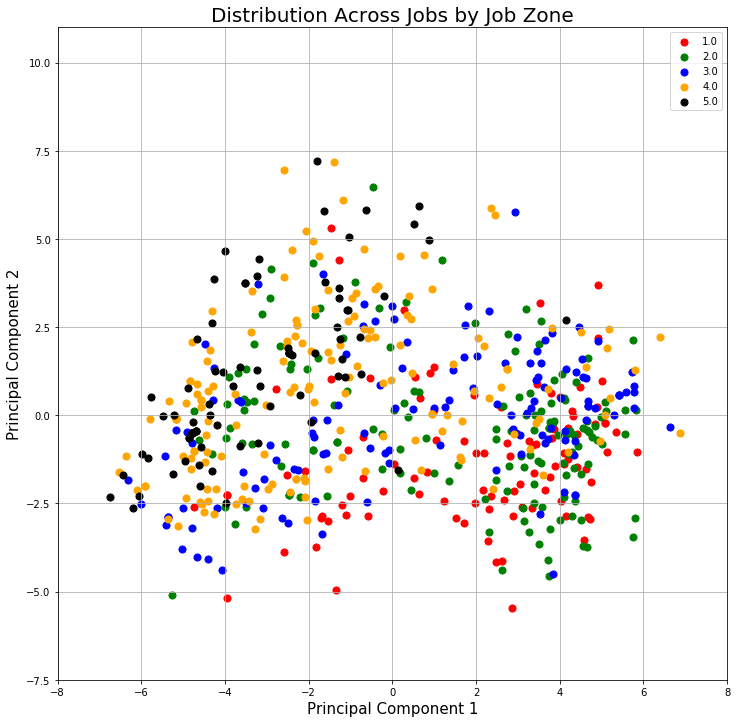

In [4]:
temp = pd.read_csv('activity_old_rca.csv')
finalDf = pca_df(temp, value = 'rca')
render_pca_plot(finalDf)

temp2 = temp.pivot_table(index = ['O*NET-SOC Code'], columns = 'Element Name', values = 'rca').reset_index()
df = pd.merge(temp2, finalDf, on = ['O*NET-SOC Code'])
df = df.corr()
df = df.drop('Job Zone', 1)
df = df.drop(['Job Zone'])
print df[['principal component 1']].sort_values('principal component 1', ascending = False).head(6)
print df[['principal component 2']].sort_values('principal component 2', ascending = False).head(7)

## Deep Dive into PCA
After the 4th dimension, the explained variance levels out.

#### the below is analysis of the second period

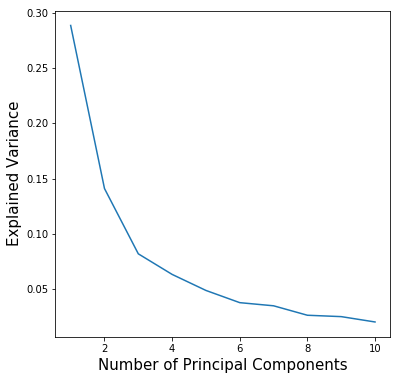

In [56]:
temp = pd.read_csv('activity_new_rca.csv')

#examine the level or importance
temp = temp[temp['Scale ID']=='IM']
temp = temp.pivot_table(index = ['O*NET-SOC Code','Job Zone'], columns = 'Element Name', values = 'rca').reset_index()
columns = temp.columns.tolist()
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Number of Principal Components', fontsize = 15)
ax.set_ylabel('Explained Variance', fontsize = 15)
    
features =  [str(col) for col in columns if col not in ['Title','O*NET-SOC Code','Job Zone'] ]
x = temp.loc[:, features].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)  
plt.plot(range(1,11), pca.explained_variance_ratio_)



Some of the skills show up multiple times as the highest correlated skill with the respective components. For example, `Active Listening` and `Reading Comprehension` are among the top 5 in PC3 and PC4. This makes the interpretation of each PC a little bit more difficult.

#### the below is analysis of the first period

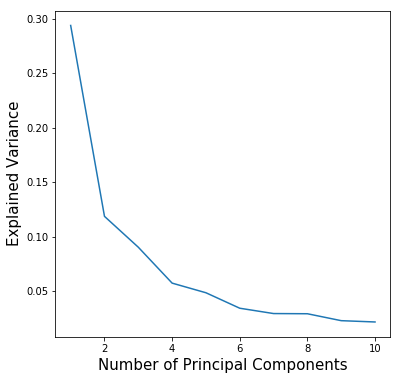

In [57]:
temp = pd.read_csv('activity_old_rca.csv')

#examine the level or importance
temp = temp[temp['Scale ID']=='IM']
temp = temp.pivot_table(index = ['O*NET-SOC Code','Job Zone'], columns = 'Element Name', values = 'rca').reset_index()
columns = temp.columns.tolist()
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Number of Principal Components', fontsize = 15)
ax.set_ylabel('Explained Variance', fontsize = 15)
    
features =  [str(col) for col in columns if col not in ['Title','O*NET-SOC Code','Job Zone'] ]
x = temp.loc[:, features].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)  
plt.plot(range(1,11), pca.explained_variance_ratio_)

### PCA on Changes in Activity Importances

This analysis examines the change in `Data value` in two periods, and examine what are the Principal Components on those changes

In [35]:
df = pd.merge(activity_old, activity_new, on = ['O*NET-SOC Code','Element ID','Scale ID', 'Element Name'], how = 'outer')
df['value_gap'] = df['Data Value_y'] - df['Data Value_x']
df['percent_change'] = df['value_gap']/df['Data Value_x']*100

temp = df.pivot_table(index = ['O*NET-SOC Code'], columns = 'Element Name', values = 'value_gap').reset_index()
columns = temp.columns.tolist()
features =  [str(col) for col in columns if col not in ['O*NET-SOC Code','Job Zone'] ]
x = temp.loc[:, features].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, temp[['O*NET-SOC Code']]], axis = 1)
finalDf = pd.merge(finalDf, jobzones_new, on = 'O*NET-SOC Code', how = 'left' )
# merge with 2018 employeent data
pd.merge(finalDf, activity_new, )

,principal component 1,principal component 2,O*NET-SOC Code,Job Zone
0,6.689193,1.506812,11-1011,5.0
1,11.294518,1.842374,11-2011,4.0
2,8.079330,-0.684102,11-2021,4.0
3,6.875667,-1.676481,11-2022,4.0
4,3.002501,2.453800,11-3011,3.0


In [21]:
temp.head()

Element Name,O*NET-SOC Code,Analyzing Data or Information,Assisting and Caring for Others,Coaching and Developing Others,Communicating with Persons Outside Organization,"Communicating with Supervisors, Peers, or Subordinates",Controlling Machines and Processes,Coordinating the Work and Activities of Others,Developing Objectives and Strategies,Developing and Building Teams,...,Provide Consultation and Advice to Others,Repairing and Maintaining Electronic Equipment,Repairing and Maintaining Mechanical Equipment,Resolving Conflicts and Negotiating with Others,Scheduling Work and Activities,Selling or Influencing Others,Staffing Organizational Units,Thinking Creatively,Training and Teaching Others,Updating and Using Relevant Knowledge
0,11-1011,-0.475,0.71,0.115,0.12,-0.005,0.38,-0.55,-0.09,0.005,...,-0.445,0.115,0.165,-0.265,0.175,-0.40,-0.755,0.60,0.145,0.375
1,11-2011,-0.900,0.87,-0.710,-0.29,-0.580,0.69,-1.43,-1.08,-1.370,...,-2.020,0.340,0.210,-0.840,-0.820,-1.19,-1.370,-0.11,-0.420,0.120
2,11-2021,-0.750,0.44,0.530,-0.46,-0.080,0.20,-0.36,-0.43,0.250,...,-1.480,0.150,0.140,0.020,-0.760,-0.23,-0.580,0.28,0.640,0.000
3,11-2022,-0.080,-0.44,0.700,-0.25,-0.040,-0.58,0.21,-0.03,0.560,...,0.660,-0.900,-0.350,0.280,-0.150,0.56,-0.520,0.45,0.490,-0.430
4,11-3011,-0.080,0.16,0.500,-0.14,0.430,1.40,0.56,-0.10,1.190,...,-0.070,1.060,1.090,0.070,0.810,0.02,0.210,0.06,0.720,0.510


### Measure of Polarization
This process takes data at a given time, and then we use MDS to measure similarity of jobs. MDS attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.
So to do that, we have to first give the model a "distance matrix" for jobs that approximate distance between different jobs by their skill requirement. This is done by multiplying the job-skill matrix by its transpose. We then fit the MDS model with distance matrix, and select the top 2 dimensions that explain distance between jobs.

Result analysis: In both periods, the first dimension is more concerned with cognitive skills, and the second dimenion is more on manual work.

In the second period, PC2 appears to cover more distance, i.e. the distance between the top and bottom is greater than that of the first period.

2nd period                                                      PC1
PC1                                             1.000000
Handling and Moving Objects                     0.546233
Controlling Machines and Processes              0.515050
Repairing and Maintaining Mechanical Equipment  0.487006
Performing General Physical Activities          0.457698
Inspecting Equipment, Structures, or Material   0.369355
                                                         PC2
PC2                                                 1.000000
Interacting With Computers                          0.081956
Establishing and Maintaining Interpersonal Rela...  0.041509
Performing Administrative Activities                0.037170
Job Zone                                            0.031932
Communicating with Persons Outside Organization     0.014629
None


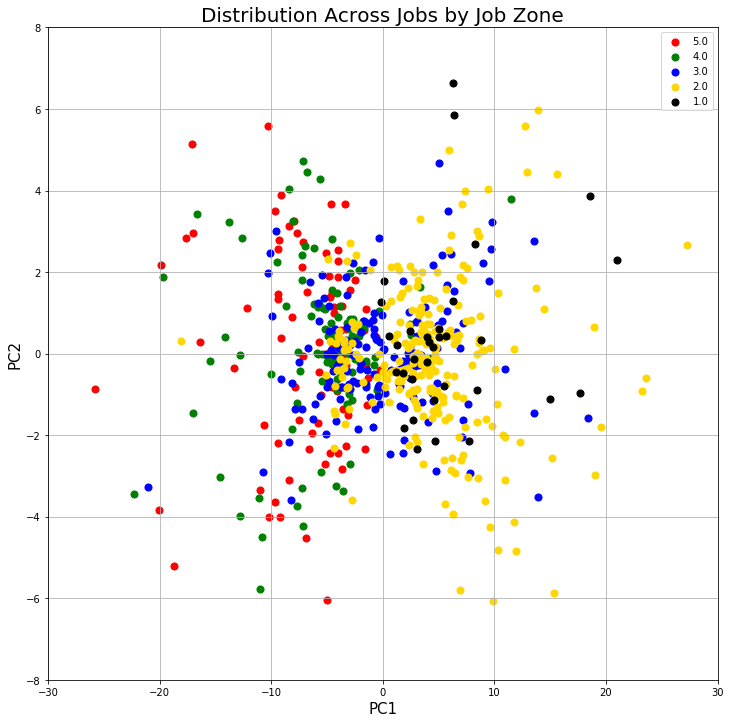

In [59]:

print '2nd period', mds(activity_new, color_code = 'job_zone')


                                                     PC1
PC1                                             1.000000
Handling and Moving Objects                     0.546233
Controlling Machines and Processes              0.515050
Repairing and Maintaining Mechanical Equipment  0.487006
Performing General Physical Activities          0.457698
Inspecting Equipment, Structures, or Material   0.369355
                                                         PC2
PC2                                                 1.000000
Interacting With Computers                          0.081956
Establishing and Maintaining Interpersonal Rela...  0.041509
Performing Administrative Activities                0.037170
Job Zone                                            0.031932
Communicating with Persons Outside Organization     0.014629


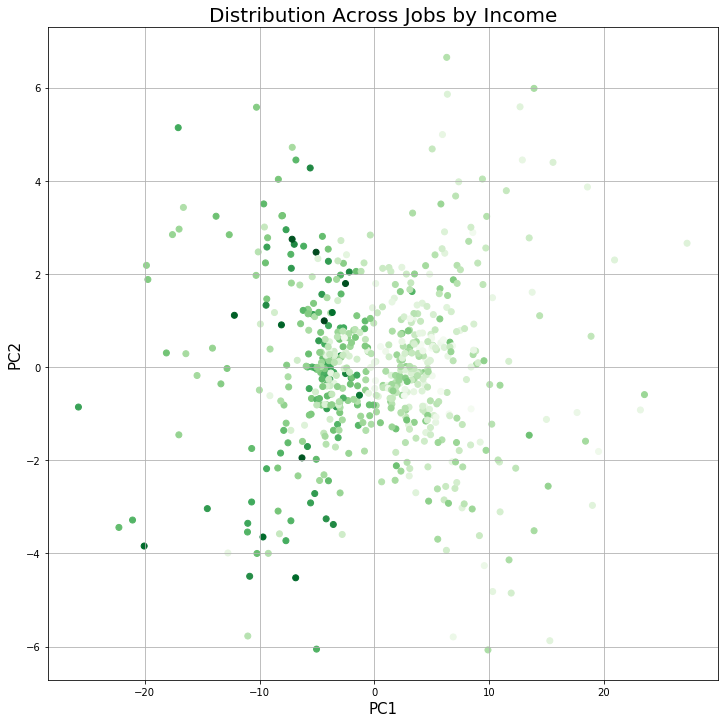

In [61]:
mds(activity_new, color_code = 'income')

first period                                                          PC1
PC1                                                 1.000000
Developing Objectives and Strategies                0.783520
Provide Consultation and Advice to Others           0.779239
Organizing, Planning, and Prioritizing Work         0.765092
Interpreting the Meaning of Information for Others  0.764760
Establishing and Maintaining Interpersonal Rela...  0.757208
                                                         PC2
PC2                                                 1.000000
Coordinating the Work and Activities of Others      0.071633
Assisting and Caring for Others                     0.067821
Performing for or Working Directly with the Public  0.066594
Communicating with Supervisors, Peers, or Subor...  0.063342
Selling or Influencing Others                       0.052015
None


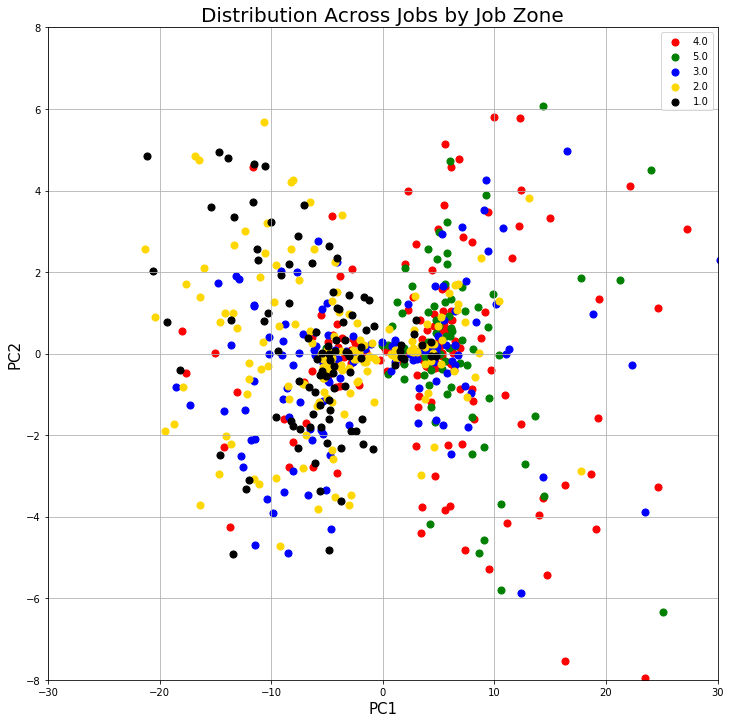

In [63]:

print 'first period', mds(activity_old)

1st period                                                          PC1
PC1                                                 1.000000
Developing Objectives and Strategies                0.783520
Provide Consultation and Advice to Others           0.779239
Organizing, Planning, and Prioritizing Work         0.765092
Interpreting the Meaning of Information for Others  0.764760
Establishing and Maintaining Interpersonal Rela...  0.757208
                                                         PC2
PC2                                                 1.000000
Coordinating the Work and Activities of Others      0.071633
Assisting and Caring for Others                     0.067821
Performing for or Working Directly with the Public  0.066594
Communicating with Supervisors, Peers, or Subor...  0.063342
Selling or Influencing Others                       0.052015
None


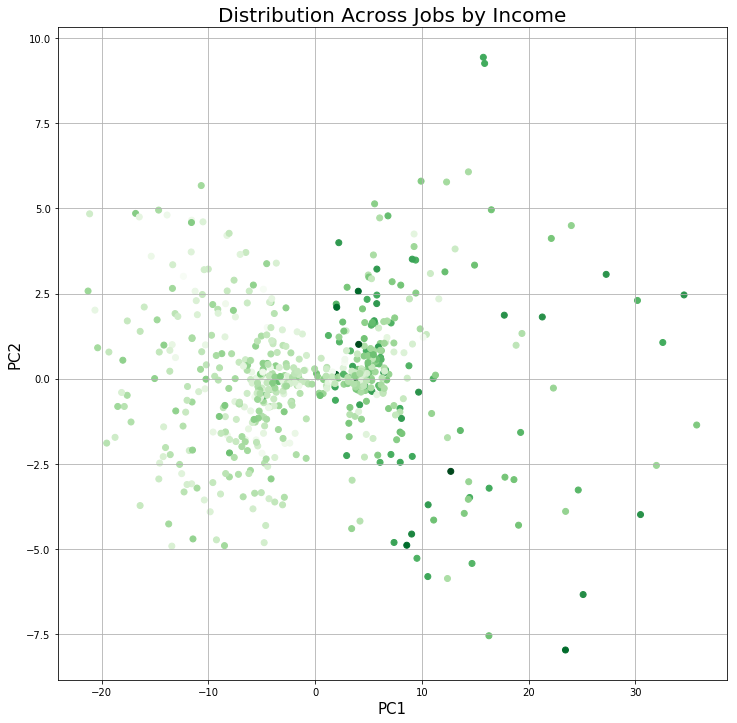

In [64]:
print '1st period', mds(activity_old, color_code = 'income', cm_scheme = 'Greens')


In [ ]:
## Calculate differences in Job distances?


## New Jobs and Disappeared Jobs

In [65]:
print 'skills that are most important in new jobs', df_newjobs.groupby(['Element Name'])['Data Value'].median().sort_values(ascending = False).reset_index().head(10)

print  'skills that are most important in  disappeared jobs', df_disappearedjobs.groupby(['Element Name'])['Data Value'].median().sort_values(ascending = False).reset_index().head(10)

skills that are most important in new jobs                                         Element Name  Data Value
0              Updating and Using Relevant Knowledge       4.455
1                                Getting Information       4.450
2              Making Decisions and Solving Problems       4.415
3  Communicating with Supervisors, Peers, or Subo...       4.380
4  Establishing and Maintaining Interpersonal Rel...       4.290
5        Organizing, Planning, and Prioritizing Work       4.175
6           Identifying Objects, Actions, and Events       4.090
7                             Processing Information       4.070
8                      Analyzing Data or Information       4.065
9                         Interacting With Computers       3.980
skills that are most important in  disappeared jobs                                         Element Name  Data Value
0                                Getting Information        3.66
1                        Handling and Moving Objects        

Interestingly, `programming` is among the lest important skills that are valued in new jobs

In [180]:
print 'skills that are least important in new jobs', df_newjobs.groupby(['Element Name'])['Data Value'].median().sort_values(ascending = True).reset_index().head(10)


skills that are least important in new jobs                         Element Name  Data Value
0              Equipment Maintenance        1.00
1                       Installation        1.00
2                          Repairing        1.00
3                Equipment Selection        1.25
4                        Programming        1.50
5                  Technology Design        1.62
6                    Troubleshooting        1.75
7              Operation and Control        1.88
8  Management of Financial Resources        1.88
9   Management of Material Resources        2.00
